In [0]:
# File location and type
file_location = "/FileStore/tables/stroke.csv"
file_type = "csv"

# CSV options
infer_schema = "True"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(df)

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,N/A,Unknown,1
60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import mlflow
import mlflow.sklearn
import sklearn

In [0]:
from mlflow.tracking import MlflowClient
# Create an experiment with a name that is unique and case sensitive.
client = MlflowClient()
#experiment_id = client.create_experiment("/Users/minzl@uchicago.edu/homework2")
experiment_id='4202382323661582'
client.set_experiment_tag(experiment_id, "Clean_data Models","random_forest")

# Fetch experiment metadata information
experiment = client.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: /Users/minzl@uchicago.edu/homework2
Experiment_id: 4202382323661582
Artifact Location: dbfs:/databricks/mlflow-tracking/4202382323661582
Tags: {'Clean_data Models': 'random_forest', 'mlflow.experimentType': 'MLFLOW_EXPERIMENT', 'mlflow.ownerId': '3352140302272092', 'mlflow.ownerEmail': 'minzl@uchicago.edu'}
Lifecycle_stage: active


In [0]:
df = df.toPandas()

# oversampling minority class
stroke_oversampled = df[df['stroke'] == 1].sample(len(df[df['stroke'] == 0]), replace=True)
clean = pd.concat([df[df['stroke'] == 0], stroke_oversampled], axis=0)

with mlflow.start_run(run_name = 'data_clean',experiment_id = experiment_id):
    clean['bmi'] = clean['bmi'].apply(lambda x: float(x) if x != 'N/A' else np.nan)
    clean['bmi'] = clean['bmi'].fillna(clean['bmi'].mean())

    dt_final = clean.drop(['id'], axis = 1)
    dt_final = pd.get_dummies(dt_final, columns=['gender', 'ever_married',
                                             'work_type', 'Residence_type','smoking_status'], 
                          drop_first=True, dtype=np.int64)
    X = dt_final.drop(columns=['stroke'])
    y = dt_final.stroke
    test_weight = 0.2
    random_state = 8
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size = test_weight, random_state = random_state)
    mlflow.log_param('test_weight',0.2)
    mlflow.log_param('random_state',8)
dt_final.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
249,3.0,0,0,95.12,18.0,0,1,0,0,0,0,0,1,0,0,0,0
250,58.0,1,0,87.96,39.2,0,1,0,1,0,1,0,0,1,0,1,0
251,8.0,0,0,110.89,17.6,0,0,0,0,0,1,0,0,1,0,0,0
252,70.0,0,0,69.04,35.9,0,0,0,1,0,1,0,0,0,1,0,0
253,14.0,0,0,161.28,19.1,0,1,0,0,1,0,0,0,0,0,0,0


In [0]:
y_test

Out[14]: 91      1
27      1
2288    0
1778    0
227     1
       ..
4148    0
2361    0
603     0
1461    0
88      1
Name: stroke, Length: 1945, dtype: int32

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
with mlflow.start_run(run_name = 'random_forest',experiment_id = experiment_id):
    n_estimators = 1000
    max_depth = 50
    bootstrap=False
    min_samples_split=5
    # Create and train model
    rf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, bootstrap=bootstrap,min_samples_split=min_samples_split)
    rf.fit(X_train, y_train)
    # Make predictions
    y_test_pred = rf.predict(X_test)
    y_train_pred = rf.predict(X_train)
  
    # Log parameters
    mlflow.log_param("num_trees", n_estimators)
    mlflow.log_param("maxdepth", max_depth)
    mlflow.log_param("max_feat", max_features)
  
    # Log model
    mlflow.sklearn.log_model(rf, "random-forest-model")
  
    # Create metrics
    classification_report_train=metrics.classification_report(y_train, y_train_pred)
    classification_report_test=metrics.classification_report(y_test, y_test_pred)
    accuracy=metrics.accuracy_score(y_test, y_test_pred)
    precision=metrics.precision_score(y_test, y_test_pred)
    recall=metrics.recall_score(y_test, y_test_pred)
    f1=metrics.f1_score(y_test, y_test_pred)
    roc=metrics.roc_auc_score(y_test, y_test_pred)
    
    # Log metrics
    print("classification_report_train", classification_report_train)
    print("classification_report_test", classification_report_test)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("roc", roc)

2021/11/04 19:46:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during spark autologging: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to your Spark session as described in http://mlflow.org/docs/latest/tracking.html#automatic-logging-from-spark-experimental. Exception:
'JavaPackage' object is not callable
2021/11/04 19:46:46 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during spark autologging: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to your Spark session as described in http://mlflow.org/docs/latest/tracking.html#automatic-logging-from-spark-experimental. Exception:
'JavaPackage' object is not callable
2021/11/04 19:46:46 WARNING mlflow.utils.autologging_utils: Encountered unex

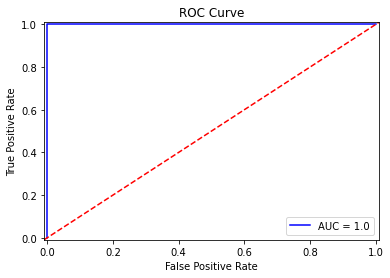

In [0]:
def roc_curve(X, y, model):
    import matplotlib.pyplot as plt

    prob = model.predict_proba(X)
    pred = prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.1f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
best_log_roc = roc_curve(X_test,y_test,rf)

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

n_estimators = list(range(200, 2200, 200))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(10, 120, 10)) + [None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

search_space = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 200, 2200, 200)),
  'max_depth': scope.int(hp.quniform('max_depth', 10, 120, 10))  
}



def train_model_rf(params):
    mlflow.autolog()
    # Enable autologging on each worker
    with mlflow.start_run(nested=True,experiment_id = experiment_id):
        rf = RandomForestClassifier(
        random_state=0,
        **params)
        rf.fit(X_train, y_train)
        predicted_probs = rf.predict_proba(X_test)
        predictions = rf.predict(X_test)
        
        # Create metrics
        accuracy=metrics.accuracy_score(y_test, y_test_pred)
        precision=metrics.precision_score(y_test, y_test_pred)
        recall=metrics.recall_score(y_test, y_test_pred)
        f1=metrics.f1_score(y_test, y_test_pred)
        roc=metrics.roc_auc_score(y_test, y_test_pred)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("roc", roc)
    return {'status': STATUS_OK, 'loss': -1*f1}

    
with mlflow.start_run(run_name='rf_hyperopt',experiment_id = experiment_id) as run:
  # Use hyperopt to find the parameters yielding the highest f1 score
    best_params = fmin(
    fn=train_model_rf, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=32)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]2021/11/04 19:29:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

2021/11/04 19:29:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.

2021/11/04 19:29:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during spark autologging: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to your Spark session as described in http://mlflow.org/docs/latest/tracking.html#automatic-logging-from-spark-experimental. Exception:
'JavaPackage' object is not callable

2021/11/04 19:29:04 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for pyspark: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to y

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
with mlflow.start_run(run_name = 'logistic',experiment_id = experiment_id):
    solver = 'newton-cg'
    penalty='l2'
    C=7000
    # Create and train model
    logistic = LogisticRegression(solver = solver, penalty = penalty, C=C)
    logistic.fit(X_train, y_train)
    # Make predictions
    y_test_pred = logistic.predict(X_test)
    y_train_pred = logistic.predict(X_train)
  
    # Log parameters
    mlflow.log_param("solver", solver)
    mlflow.log_param("penalty", penalty)
    mlflow.log_param("C", C)
  
    # Log model
    mlflow.sklearn.log_model(logistic, "logistic-model")
  
    # Create metrics
    classification_report_train=metrics.classification_report(y_train, y_train_pred)
    classification_report_test=metrics.classification_report(y_test, y_test_pred)
    accuracy=metrics.accuracy_score(y_test, y_test_pred)
    precision=metrics.precision_score(y_test, y_test_pred)
    recall=metrics.recall_score(y_test, y_test_pred)
    f1=metrics.f1_score(y_test, y_test_pred)
    roc=metrics.roc_auc_score(y_test, y_test_pred)
    
    # Log metrics
    print("classification_report_train", classification_report_train)
    print("classification_report_test", classification_report_test)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("roc", roc)

2021/11/04 19:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during spark autologging: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to your Spark session as described in http://mlflow.org/docs/latest/tracking.html#automatic-logging-from-spark-experimental. Exception:
'JavaPackage' object is not callable
2021/11/04 19:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during spark autologging: Exception while attempting to initialize JVM-side state for Spark datasource autologging. Please create a new Spark session and ensure you have the mlflow-spark JAR attached to your Spark session as described in http://mlflow.org/docs/latest/tracking.html#automatic-logging-from-spark-experimental. Exception:
'JavaPackage' object is not callable
2021/11/04 19:55:52 WARNING mlflow.utils.autologging_utils: Encountered unex

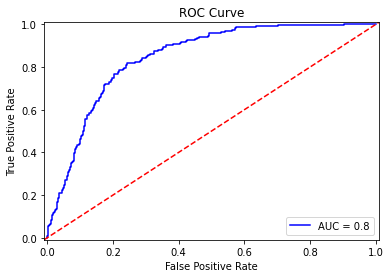

In [0]:
best_log_roc = roc_curve(X_test,y_test,logistic)